<a href="https://colab.research.google.com/github/paolominguzzi/AI_Supply_Chain/blob/master/Market_Cluster_Based_on_Distance_and_Volume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from collections import deque
import random

In [ ]:
from google.colab import files
uploaded = files.upload()  # Manually upload your PDF files her

Saving PreciosdiariostodoslosproductossinIVAproCoordenatesMercadoyOrigenv4.xlsx to PreciosdiariostodoslosproductossinIVAproCoordenatesMercadoyOrigenv4.xlsx


In [ ]:
import pandas as pd

# Load Excel file
file_name = 'PreciosdiariostodoslosproductossinIVAproCoordenatesMercadoyOrigenv4.xlsx'  # Replace with your file name
data = pd.read_excel(file_name, sheet_name=None)  # Load all sheets into a dictionary of DataFrames

# Example: If there's a specific sheet you want
df = pd.read_excel(file_name, sheet_name='series-historicas')  # Replace 'Sheet1' with the actual sheet name

In [ ]:
# Step 2: Load the dataset
file_name = "PreciosdiariostodoslosproductossinIVAproCoordenatesMercadoyOrigenv4.xlsx"  # Update the filename if necessary
df = pd.read_excel(file_name, sheet_name="series-historicas")

In [ ]:
# Step 3: Data preprocessing
# Extract latitude and longitude for markets and origins
df[['Lat_Mercado', 'Lon_Mercado']] = df['Mercado Coordenadas'].str.split(', ', expand=True).astype(float)
df[['Lat_Origen', 'Lon_Origen']] = df['Procedencia Coordenates'].str.split(', ', expand=True).astype(float)

In [ ]:
# Step 3: Data preprocessing
# Extract latitude and longitude for markets and origins
df[['Lat_Mercado', 'Lon_Mercado']] = df['Mercado Coordenadas'].str.split(', ', expand=True).astype(float)
df[['Lat_Origen', 'Lon_Origen']] = df['Procedencia Coordenates'].str.split(', ', expand=True).astype(float)

In [ ]:
# Calculate distances between market and origin
df['Distance'] = np.sqrt((df['Lat_Mercado'] - df['Lat_Origen'])**2 + (df['Lon_Mercado'] - df['Lon_Origen'])**2)

In [ ]:
# Aggregate data by market and product
market_data = df.groupby(['Mercado', 'Producto']).agg({
    'Distance': 'mean',
    'Volumen': 'sum',
    'Precio promedio ponderado': 'mean'
}).reset_index()

In [ ]:
# Step 4: K-Means Clustering to group similar markets
kmeans = KMeans(n_clusters=5, random_state=42)
market_data['Cluster'] = kmeans.fit_predict(market_data[['Distance', 'Volumen']])

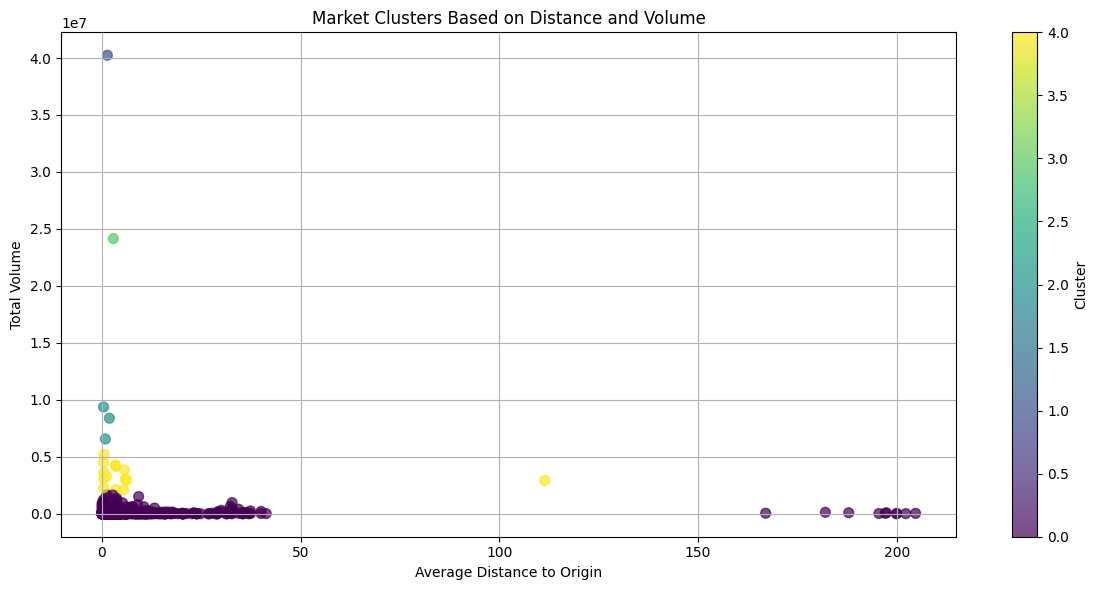

In [ ]:
# Visualize clusters
plt.figure(figsize=(12, 6))
plt.scatter(market_data['Distance'], market_data['Volumen'], c=market_data['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label="Cluster")
plt.xlabel('Average Distance to Origin')
plt.ylabel('Total Volume')
plt.title('Market Clusters Based on Distance and Volume')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Step 5: Random Forest for volume prediction
# Train a Random Forest Regressor to predict future volumes
X = market_data[['Distance', 'Cluster']]
y = market_data['Volumen']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
# Predict future volumes
market_data['Predicted_Volume'] = model.predict(X)

In [ ]:
# Step 6: Reinforcement Learning for optimization prescriptions
# Define state, action, and reward
state_size = 2  # Distance and Volume
action_size = 3  # Example actions: {0: "increase production", 1: "maintain", 2: "decrease production"}

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Dense(24, input_dim=self.state_size, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
# Train the DQN agent
agent = DQNAgent(state_size, action_size)
batch_size = 32

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Convert data for DQN
states = market_data[['Distance', 'Predicted_Volume']].values
for epoch in range(100):
    for i in range(len(states) - 1):
        state = states[i].reshape(1, state_size)
        next_state = states[i + 1].reshape(1, state_size)
        action = agent.act(state)
        reward = -abs(market_data['Predicted_Volume'].iloc[i] - market_data['Volumen'].iloc[i])
        agent.remember(state, action, reward, next_state, False)
    agent.replay(batch_size)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step